In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.read_csv('/kaggle/input/titanic/train.csv')

#describe dataset
print(train_df.describe())

#identify missing 
print(train_df.isna().sum())

train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

print(train_df.isna().sum())

#identify datatype
print(train_df.dtypes)


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

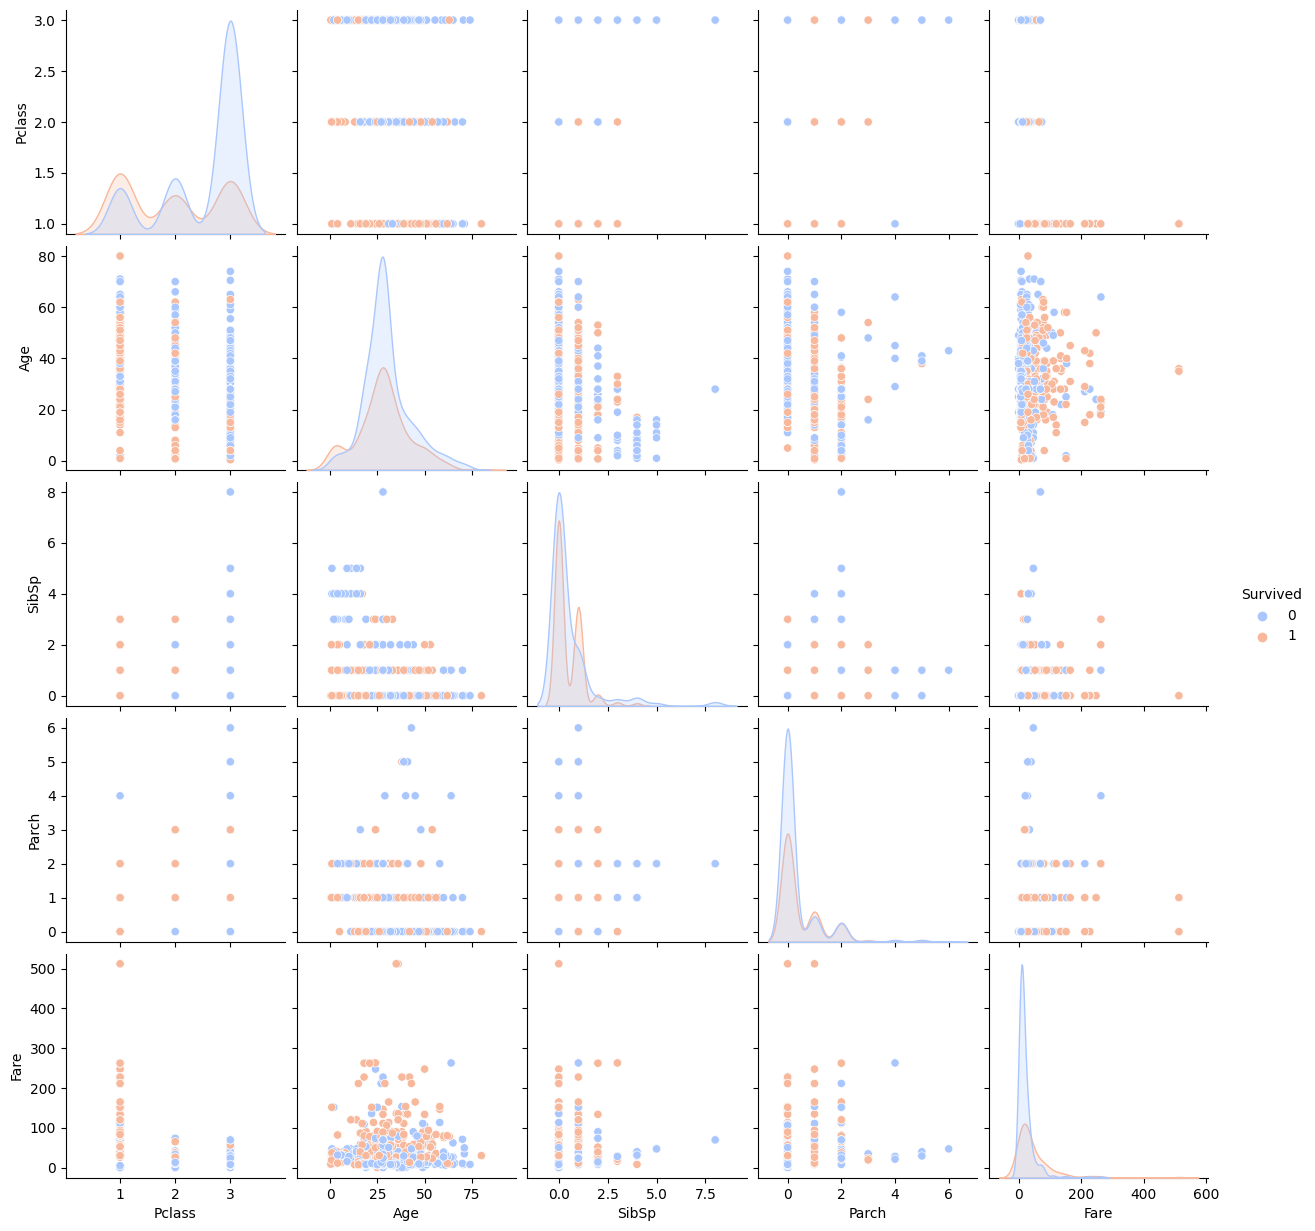

In [2]:
#plot numerical columns
num_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']
sns.pairplot(train_df[num_columns], hue='Survived', palette='coolwarm')
plt.show()



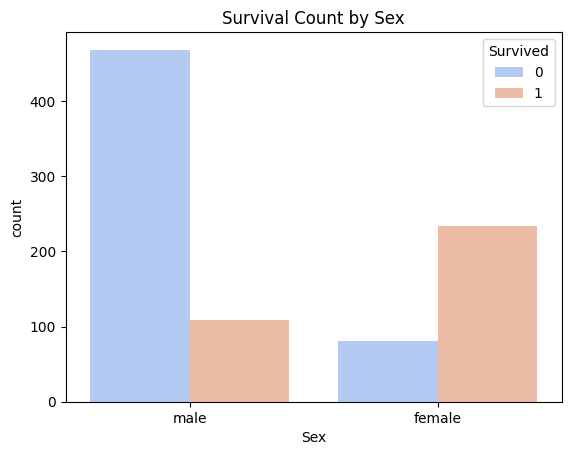

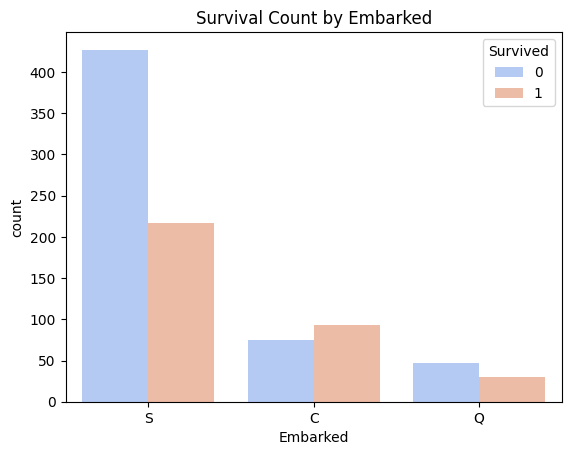

In [3]:
#plot categorical columns 
sns.countplot(data=train_df, x='Sex', hue='Survived', palette='coolwarm')
plt.title('Survival Count by Sex')
plt.show()

sns.countplot(data=train_df, x='Embarked', hue='Survived', palette='coolwarm')
plt.title('Survival Count by Embarked')
plt.show()


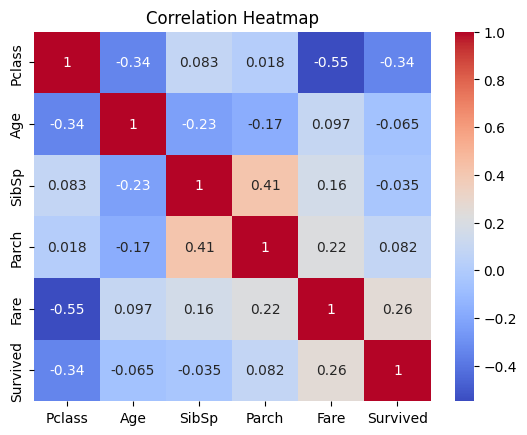

In [4]:
#correlation analysis for numerical
correlation_matrix = train_df[num_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = train_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']]
X = pd.get_dummies(X, drop_first=True)
y = train_df['Survived']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

print(feature_df)

      Feature  Importance
4        Fare    0.277685
1         Age    0.260952
5    Sex_male    0.258437
0      Pclass    0.079910
2       SibSp    0.050445
3       Parch    0.038166
7  Embarked_S    0.024022
6  Embarked_Q    0.010383


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

results = {}

for model_name, model in models.items():

    model.fit(X_train_scaled if model_name in ['KNN', 'Neural Network'] else X_train, y_train)
    
    y_pred = model.predict(X_test_scaled if model_name in ['KNN', 'Neural Network'] else X_test)
    
    # classification metrics (only for classification models)
    if model_name in ['KNN', 'Random Forest', 'Neural Network', 'XGBoost']:
        y_pred_class = (y_pred > 0.5).astype(int)
        
        recall = recall_score(y_test, y_pred_class)
        precision = precision_score(y_test, y_pred_class)
        results[model_name] = {
            'Recall': recall,
            'Precision': precision
        }
    
    # Regression metrics (for regression tasks like Linear Regression)
    else:
        r2 = r2_score(y_test, y_pred) if model_name != 'Linear Regression' else None
        mae = mean_absolute_error(y_test, y_pred)
        
        results[model_name] = {
            'R2': r2,
            'MAE': mae
        }

for model_name, metrics in results.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Linear Regression Performance:
MAE: 0.2853

KNN Performance:
Recall: 0.7297
Precision: 0.7826

Random Forest Performance:
Recall: 0.7703
Precision: 0.7808

Neural Network Performance:
Recall: 0.7027
Precision: 0.8254

XGBoost Performance:
Recall: 0.7703
Precision: 0.8143


In [7]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

X = train_df.drop(columns=['Survived'])
X = X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']]
y = train_df['Survived']

label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Hyperparameters:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.8101
Recall: 0.7162
Precision: 0.8030


In [8]:
#make testing prediction
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
X_test_df = test_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']]
X_test_df['Age'] = X_test_df['Age'].fillna(X_test_df['Age'].median())
for column, le in label_encoders.items():
    X_test_df[column] = le.transform(X_test_df[column])

y_pred_test = best_model.predict(X_test_df)

<ipython-input-8-8673a63e89c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df['Age'] = X_test_df['Age'].fillna(X_test_df['Age'].median())
<ipython-input-8-8673a63e89c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df[column] = le.transform(X_test_df[column])
<ipython-input-8-8673a63e89c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [9]:
# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],  # Ensure this column exists in your test dataset
    'Survived': y_pred_test  # This is the prediction for each passenger in the test set
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)